LeViT
====

**LeViT: a Vision Transformer in ConvNet's Clothing for Faster Inference**
 * Paper: https://arxiv.org/abs/2104.01136

![LeViT Architecture](../assets/levit_architecture.png)

In [ ]:
from PIL import Image
import timm
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(
    'levit_128.fb_dist_in1k', pretrained=True
)
model.eval().to(device);

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(
    **data_config, is_training=False
)

In [20]:
image_path = "../samples/plants.jpg"
img = Image.open(image_path).convert("RGB")

with torch.no_grad():
    output = model(transforms(img).unsqueeze(0).to(device))

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1), k=5)

for i in range(5):
    print(
        f"Class: {top5_class_indices[0][i].item()}, "
        f"Probability: {top5_probabilities[0][i].item() * 100:.2f}%"
    )


Class: 738, Probability: 62.17%
Class: 883, Probability: 27.89%
Class: 725, Probability: 0.65%
Class: 503, Probability: 0.47%
Class: 773, Probability: 0.46%


In [21]:
import requests

def load_imagenet_classes():
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    response = requests.get(url)
    response.raise_for_status()  # Ensure it succeeded
    class_names = response.text.strip().split("\n")
    return class_names

# Example usage
class_names = load_imagenet_classes()

for i in range(5):
    print(
        f"Class: {class_names[top5_class_indices[0][i].item()]} "
        f"Probability: {top5_probabilities[0][i].item() * 100:.2f}%"
    )

Class: pot Probability: 62.17%
Class: vase Probability: 27.89%
Class: pitcher Probability: 0.65%
Class: cocktail shaker Probability: 0.47%
Class: saltshaker Probability: 0.46%


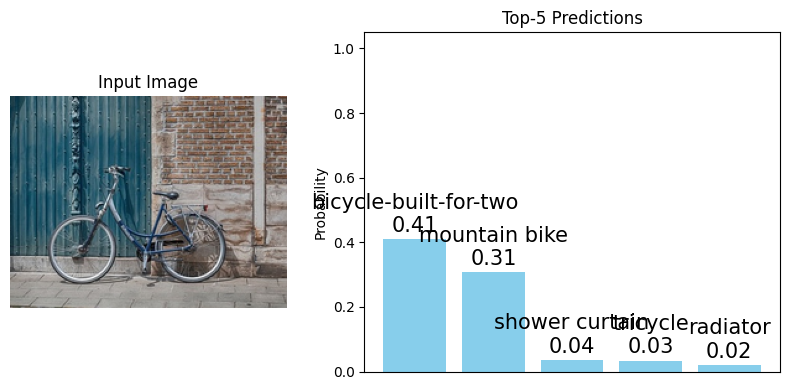

In [35]:
import numpy as np
import matplotlib.pyplot as plt


def resize_image(image, max_size=224):
    width, height = image.size
    if width > height:
        new_width = max_size
        new_height = int((max_size / width) * height)
    else:
        new_height = max_size
        new_width = int((max_size / height) * width)
    return image.resize((new_width, new_height), Image.LANCZOS)


def visualize_predictions(image: Image.Image, top5_indices, top5_probs, class_names):
    top5_labels = [class_names[i] for i in top5_indices]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1.5]})

    # Show the image
    ax1.imshow(resize_image(image))
    ax1.axis('off')
    ax1.set_title("Input Image")

    # Vertical bar chart
    x_pos = np.arange(len(top5_labels))
    bars = ax2.bar(x_pos, top5_probs, color='skyblue')

    # Add class names and probabilities on top of each bar
    for i, (bar, label, prob) in enumerate(zip(bars, top5_labels, top5_probs)):
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{label}\n{prob:.2f}",
                 ha='center', va='bottom', fontsize=15, rotation=0)

    ax2.set_xticks([])
    ax2.set_ylim(0, 1.05)
    ax2.set_ylabel('Probability')
    ax2.set_title('Top-5 Predictions')

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_predictions(
    image=img,
    top5_indices=top5_class_indices[0].cpu().numpy(),
    top5_probs=top5_probabilities[0].cpu().numpy(),
    class_names=class_names
)


Predictions for ../samples/house.jpg:


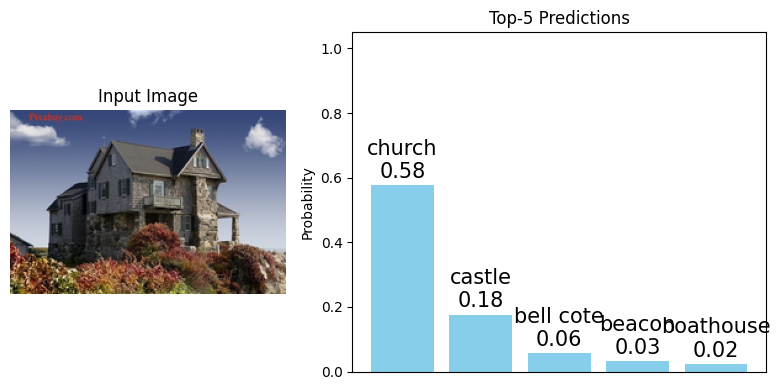


Predictions for ../samples/sealions-sf.jpg:


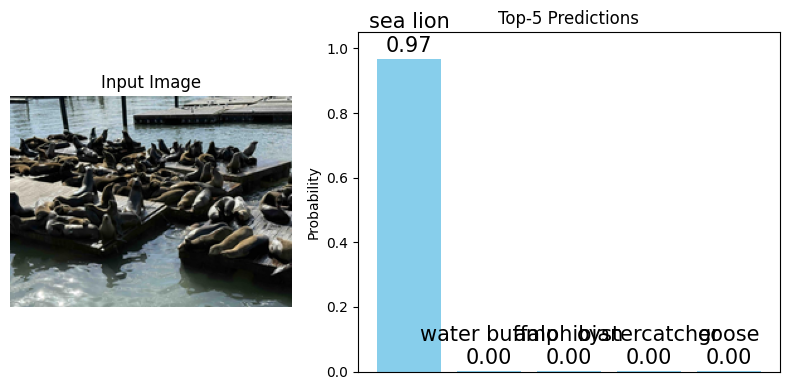


Predictions for ../samples/bicycle.jpg:


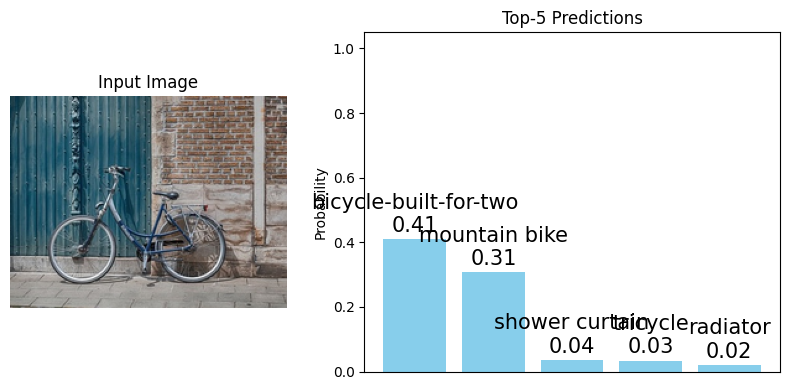

In [36]:
image_files = [
    "../samples/house.jpg",
    "../samples/sealions-sf.jpg",
    "../samples/bicycle.jpg"
]

for image_path in image_files:
    img = Image.open(image_path).convert("RGB")
    with torch.no_grad():
        output = model(transforms(img).unsqueeze(0).to(device))

    top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1), k=5)

    print(f"\nPredictions for {image_path}:")
    # Visualize the predictions
    visualize_predictions(
        image=img,
        top5_indices=top5_class_indices[0].cpu().numpy(),
        top5_probs=top5_probabilities[0].cpu().numpy(),
        class_names=class_names
    )